In [1]:
import os
import sys
import cv2
import json
import math 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from datasets import load_dataset 
from pycocotools.coco import COCO
from PIL import Image
from huggingface_hub import hf_hub_download

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),"..")))

### Load data:

In [2]:
from src.preprocess_data import load_and_split_dataset

In [3]:
HF_REPO_NAME = "peaceAsh/fashion_sam_dataset_v2"
COCO_DATASET = "peaceAsh/fashion_seg_coco_dataset"
JSON_FILE = "result.json"

In [4]:
fashion_ds = load_and_split_dataset(HF_REPO_NAME)

In [5]:
fashion_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 13
    })
    validation: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 1
    })
    test: Dataset({
        features: ['image', 'mask', 'filename'],
        num_rows: 2
    })
})

In [6]:
coco_path = hf_hub_download(
    repo_id=COCO_DATASET,
    filename=JSON_FILE,
    repo_type="dataset" 
)

coco = COCO(coco_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
coco_imgs = coco.loadImgs(coco.getImgIds())
filename_to_ids = {img['file_name'] : img['id'] for img in coco_imgs}

In [8]:
coco_imgs

[{'width': 900, 'height': 1200, 'id': 0, 'file_name': 'sample_14.jpg'},
 {'width': 2000, 'height': 3000, 'id': 1, 'file_name': 'sample_13.jpg'},
 {'width': 1000, 'height': 1500, 'id': 2, 'file_name': 'sample_12.jpg'},
 {'width': 683, 'height': 1024, 'id': 3, 'file_name': 'sample_11.jpg'},
 {'width': 1536, 'height': 2310, 'id': 4, 'file_name': 'sample_10.jpg'},
 {'width': 852, 'height': 1280, 'id': 5, 'file_name': 'sample_9.jpg'},
 {'width': 6000, 'height': 4000, 'id': 6, 'file_name': 'sample_8.jpg'},
 {'width': 1067, 'height': 1600, 'id': 7, 'file_name': 'sample_7.jpg'},
 {'width': 667, 'height': 1000, 'id': 8, 'file_name': 'sample_6.jpg'},
 {'width': 650, 'height': 975, 'id': 9, 'file_name': 'sample_5.jpg'},
 {'width': 500, 'height': 750, 'id': 10, 'file_name': 'sample_4.jpg'},
 {'width': 400, 'height': 567, 'id': 11, 'file_name': 'sample_3.jpg'},
 {'width': 1997, 'height': 3000, 'id': 12, 'file_name': 'sample_2.jpg'},
 {'width': 2448, 'height': 2448, 'id': 13, 'file_name': 'sample_1.

In [9]:
filename_to_ids

{'sample_14.jpg': 0,
 'sample_13.jpg': 1,
 'sample_12.jpg': 2,
 'sample_11.jpg': 3,
 'sample_10.jpg': 4,
 'sample_9.jpg': 5,
 'sample_8.jpg': 6,
 'sample_7.jpg': 7,
 'sample_6.jpg': 8,
 'sample_5.jpg': 9,
 'sample_4.jpg': 10,
 'sample_3.jpg': 11,
 'sample_2.jpg': 12,
 'sample_1.jpg': 13,
 'sample_0.jpg': 14}

In [10]:
def create_instance_list(dataset,coco,filename_to_ids):
    instance_list = []
    for i in tqdm(range(len(dataset))):
        item = dataset[i]
        base_filename = item['filename']
        coco_filename = base_filename.split('/')[-1]
        img_id = filename_to_ids[coco_filename]
        if img_id is not None:
            anns_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(anns_ids)
            for ann in anns:
                instance_list.append({
                    "dataset_idx":i,
                    "annotation":ann
                })
    return instance_list



train_instances = create_instance_list(fashion_ds['train'],coco,filename_to_ids)
val_instances = create_instance_list(fashion_ds['validation'],coco,filename_to_ids)

print(f"Number of images:{len(fashion_ds['train'])}")
print(f"Total training instances:{len(train_instances)}")
print(f"Number of images:{len(fashion_ds['validation'])}")
print(f"Total validation instances:{len(val_instances)}")

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Number of images:13
Total training instances:37
Number of images:1
Total validation instances:4


In [11]:
def num_masks_per_img(dataset,coco,filename_to_ids):
    instance_list = []
    for i in tqdm(range(len(dataset))):
        item = dataset[i]
        base_filename = item['filename']
        coco_filename = base_filename.split('/')[-1]
        img_id = filename_to_ids[coco_filename]
        if img_id is not None:
            anns_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(anns_ids)
            num_masks = len(anns_ids)

            
            instance_list.append({
                "filename":base_filename,
                "img_id":img_id,
                "num_masks":num_masks
            })
    instance_df = pd.DataFrame(instance_list)
    return instance_df

train_masks_df = num_masks_per_img(fashion_ds['train'],coco,filename_to_ids)
print(f"Total images in training set:{len(train_masks_df)}")
print(f"Total number of masks in training set:{train_masks_df['num_masks'].sum()}")
print(f"Images with no masks in training set:{(train_masks_df['num_masks']==0).sum()}")

  0%|          | 0/13 [00:00<?, ?it/s]

Total images in training set:13
Total number of masks in training set:37
Images with no masks in training set:0


In [12]:
train_masks_df

,filename,img_id,num_masks
0,sample_5.jpg,9,2
1,sample_11.jpg,3,4
2,sample_14.jpg,0,2
3,sample_3.jpg,11,1
4,sample_0.jpg,14,7
5,sample_4.jpg,10,6
6,sample_9.jpg,5,4
7,sample_12.jpg,2,1
8,sample_10.jpg,4,3
9,sample_2.jpg,12,1


In [19]:
def viz_masks(dataset,coco_api,filename_to_id,idx,target_size=256,max_show= 25,main_title="Instance masks"):

    sample = dataset[idx]
    base_filename = sample['filename'] 
    coco_filename = base_filename.split('/')[-1]
    img_id = filename_to_id[coco_filename]

    if img_id is None:
        print("No annotations for image:{base_filename}")
        return
    
    anns_ids = coco_api.getAnnIds(imgIds=img_id)
    anns = coco_api.loadAnns(anns_ids)
    masks = [coco_api.annToMask(ann) for ann in anns]
    print(f"Total number of masks:{len(masks)}")

    if len(masks)==0:
        print("No masks to display")
        return
    
    image = np.array(sample['image'].convert('RGB'))
    smol_image = cv2.resize(image,(target_size,target_size))
    smol_masks = [
        cv2.resize(m.astype(np.uint8),(target_size,target_size), interpolation=cv2.INTER_NEAREST)
        for m in masks
    ]

    num_masks = len(smol_masks)
    num_show = min(num_masks,max_show)

    ncols = int(math.ceil(math.sqrt(num_show+1)))
    nrows = int(math.ceil((num_show+1)/ncols))
    fig,axes = plt.subplots(nrows,ncols,figsize=(5*ncols,5*nrows))
    axes = np.array(axes).reshape(-1)

    axes[0].imshow(smol_image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    for i in range(num_show):
        ax = axes[i+1]
        ax.imshow(smol_masks[i],cmap='gray')
        ax.set_title(f"Mask {i+1}")
        ax.axis('off')

    for j in range(num_show+1,len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f"main_title:\n Total Masks={num_masks}")
    plt.tight_layout()
    plt.show()

Total number of masks:4


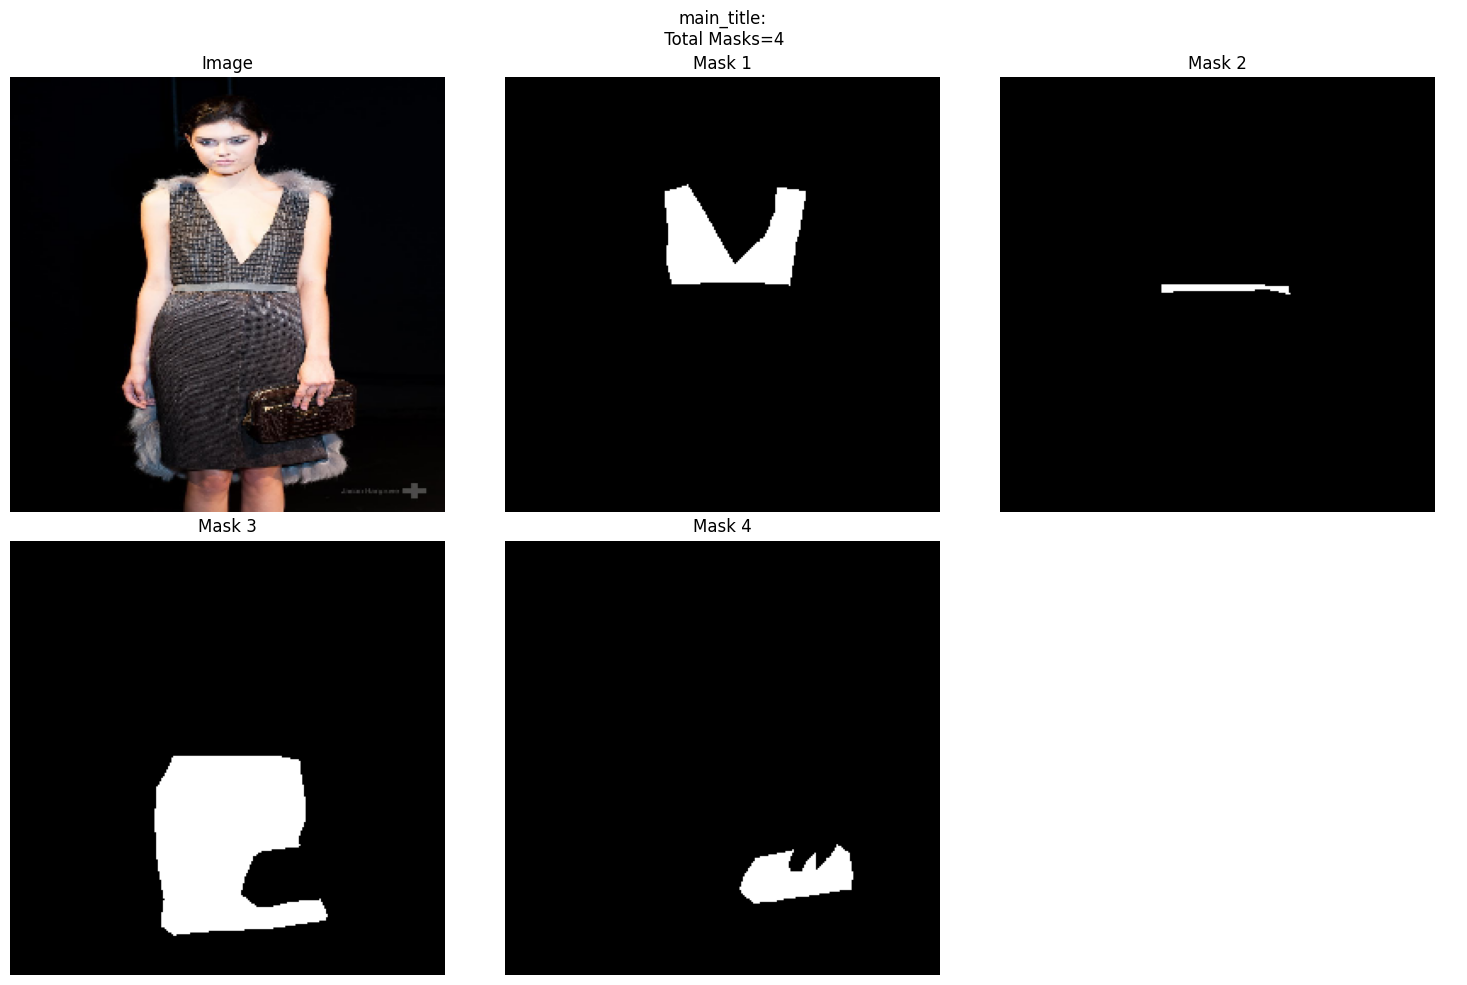

In [21]:
viz_masks(
    dataset=fashion_ds['train'],
    coco_api=coco,
    filename_to_id=filename_to_ids,
    idx=6
)

In [22]:
def sample_pts_mask(mask,num_points=3,resize_size=1024):
    h,w = mask.shape
    if max(h,w)>resize_size:
        scale = resize_size / max(h,w)
        mask = cv2.resize(mask.astype(np.uint8),(scale,scale),interpolation=cv2.INTER_NEAREST)
    else:
        scale = 1.0
    
    kernel = np.ones((3,3),np.uint8)
    eroded_mask = cv2.erode(mask,kernel,iterations=1)
    foreground_coords = np.argwhere(eroded_mask>0)

    if len(foreground_coords) == 0 :
        foreground_coords = np.argwhere(mask>0)
    if len(foreground_coords) == 0 :
        return np.empty((0,2),dtype=np.float32)
    
    num_available_pts = len(foreground_coords)
    pts_to_sample = min(num_points,num_available_pts)
    sampled_pts = foreground_coords[np.random.choice(num_available_pts,pts_to_sample,replace=False)]
    sampled_xy = sampled_pts[:,::-1]/scale
    return sampled_xy.astype(np.float32)

In [30]:
def viz_instances(image,masks,num_pts_per_mask=3,main_title="Image,mask and sampled points"):
    if not masks:
        print("No masks to display")
        return
    
    num_instances = len(masks)
    ncols = 3
    nrows = num_instances
    fig,axes = plt.subplots(nrows,ncols,figsize=(15,5*nrows))

    fig.suptitle(main_title,fontsize=14)

    for i,mask in enumerate(masks):
        points = sample_pts_mask(mask,num_points=num_pts_per_mask)

        ax_img = axes[i,0]
        ax_img.imshow(image)
        ax_img.axis('off')
        if i==0:
            ax_img.set_title("Image")
    
        ax_mask = axes[i,1]
        ax_mask.imshow(mask,cmap="gray")
        ax_mask.axis('off')
        if i==0:
            ax_mask.set_title("Mask")

        ax_pts = axes[i,2]
        ax_pts.imshow(mask)
        ax_pts.axis('off')
        if i==0:
            ax_pts.set_title("Sampled Points")

        if points.shape[0]>0:
            x_coords , y_coords = zip(*points)
            ax_pts.scatter(x_coords,y_coords,s=50,c='red',marker='x')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def viz_sampled_points(dataset,coco_api,filename_to_id,idx,num_pts_per_mask=3,target_size=1024):

    sample = dataset[idx]
    base_filename = sample['filename'] 
    coco_filename = base_filename.split('/')[-1]
    img_id = filename_to_id[coco_filename]

    if img_id is None:
        print("No annotations for image:{base_filename}")
        return
    
    anns_ids = coco_api.getAnnIds(imgIds=img_id)
    anns = coco_api.loadAnns(anns_ids)
    masks = [coco_api.annToMask(ann) for ann in anns]

    if len(masks)==0:
        print("No masks to display")
        return
    
    image = np.array(sample['image'].convert('RGB'))
    smol_image = cv2.resize(image,(target_size,target_size))
    smol_masks = [
        cv2.resize(m.astype(np.uint8),(target_size,target_size), interpolation=cv2.INTER_NEAREST)
        for m in masks
    ]

    viz_instances(
        image=smol_image,
        masks=smol_masks,
        num_pts_per_mask=num_pts_per_mask,
        main_title=f"Sampled points per mask:{num_pts_per_mask}"
    )

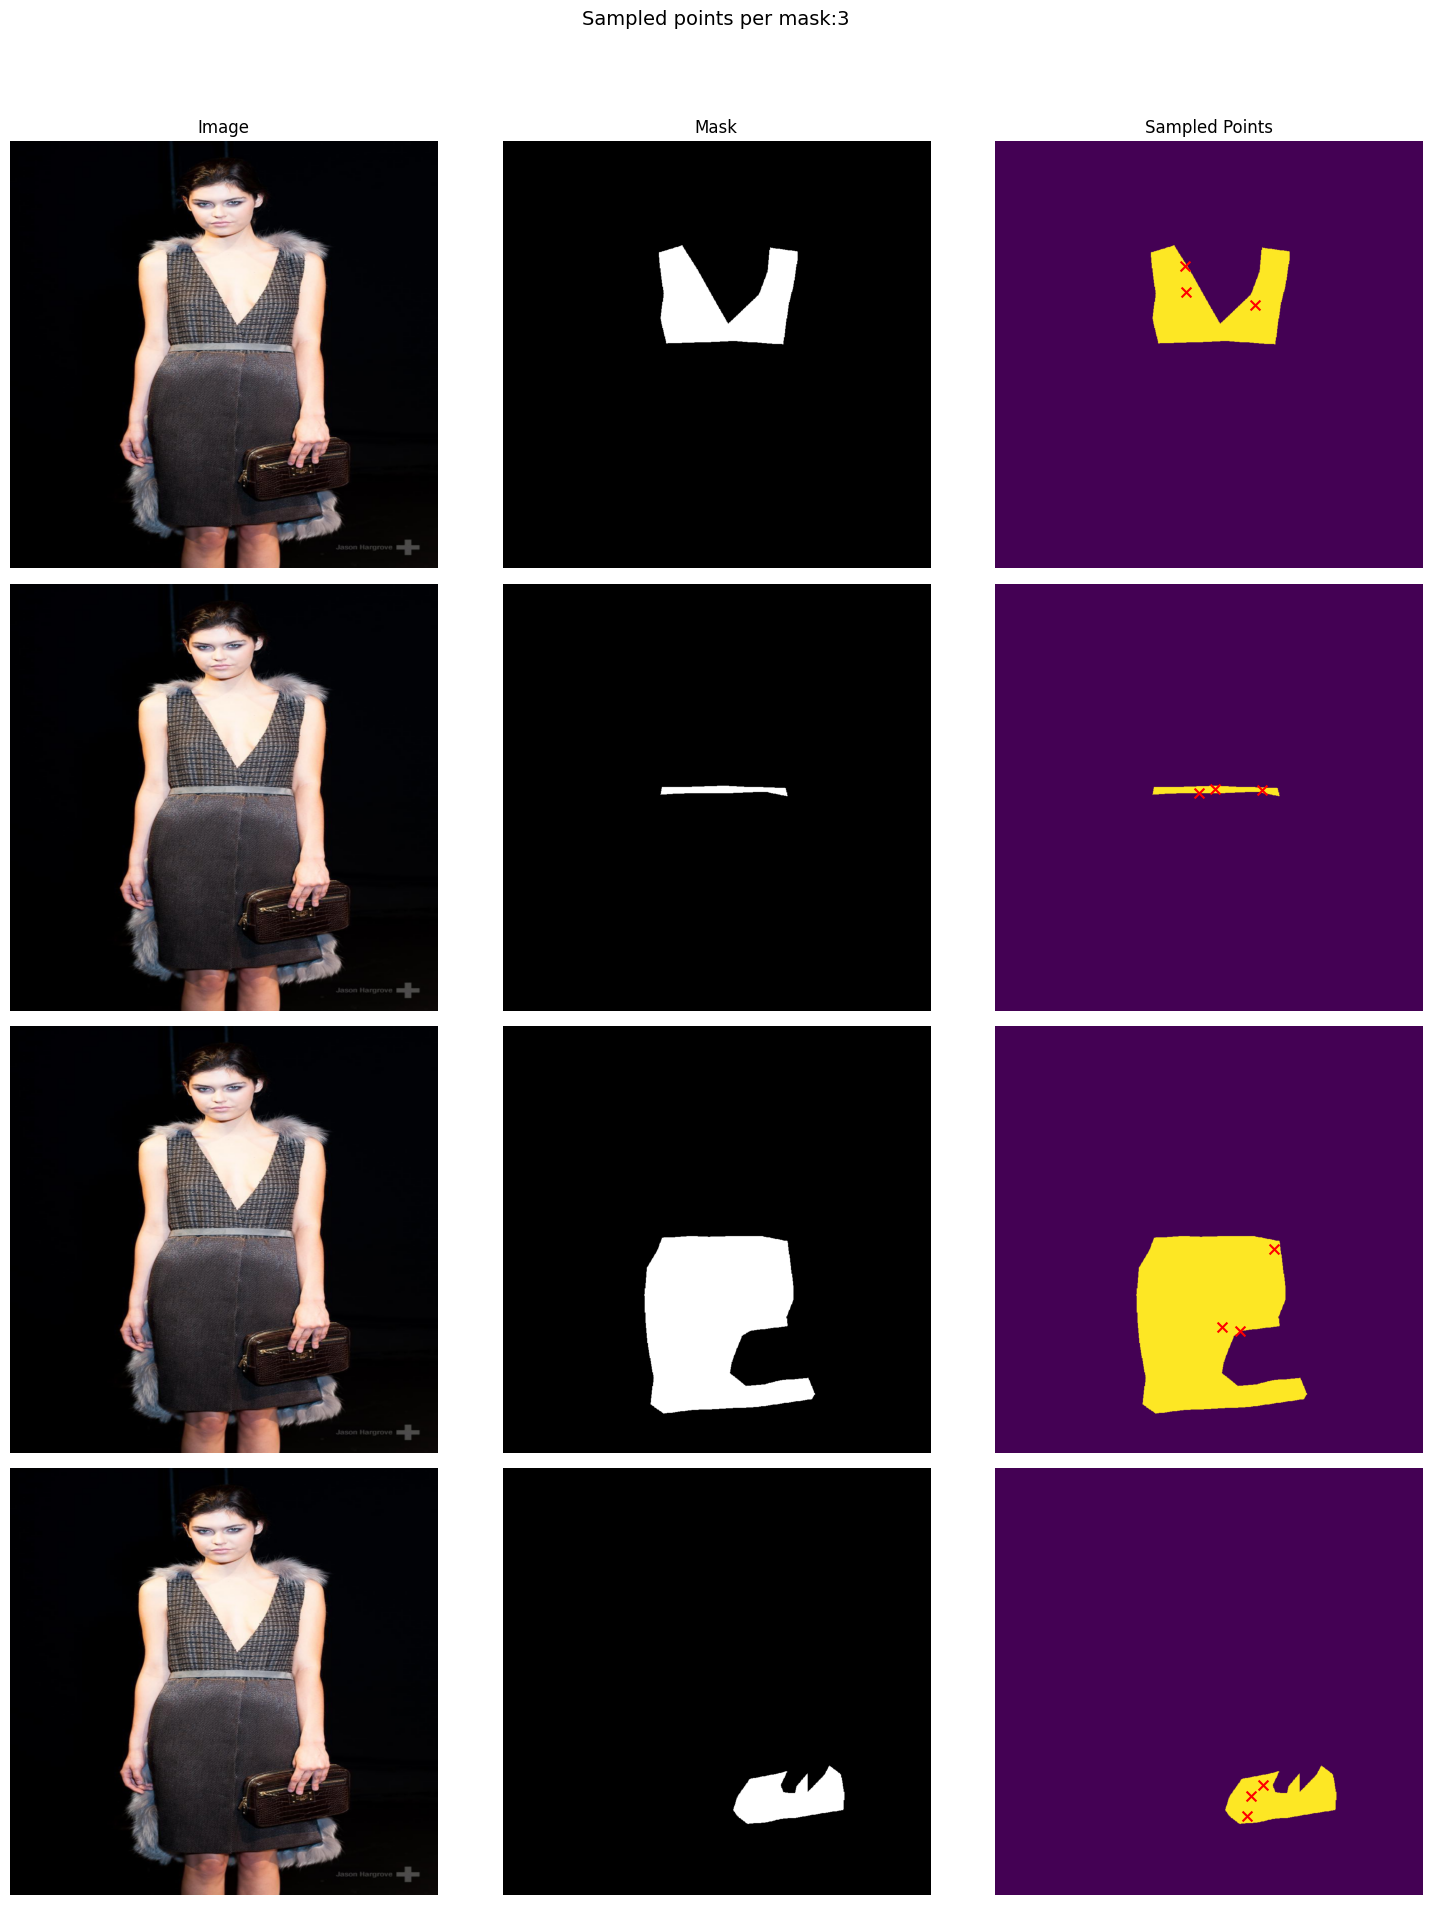

In [31]:
viz_sampled_points(
    dataset=fashion_ds['train'],
    coco_api=coco,
    filename_to_id=filename_to_ids,
    idx=6
)